In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
k = 10 # number of arms
actions = np.arange(k)
max_int = 2**32 - 1 # for random seed
np.random.seed(2019)

In [3]:
class Method(Enum):
    SAMPLE_AVERAGE = 0
    CONSTANT_STEPSIZE = 1
    UNBIASED_CONSTANT_STEPSIZE = 2
    GRADIENT_BANDIT = 3

In [4]:
def softmax(x):
    return np.exp(x) / sum(np.exp(x))

def argmax(x):
    # Better than np.argmax(x) for breaking ties randomly
    return np.random.choice(np.flatnonzero(x == x.max()))

def run(method, n_steps=1000, mean=0.0, stddev=1.0, epsilon=0.1, alpha=0.1,
        stationary=True, mean_inc=0.0, stddev_inc=0.01,
        optimistic=False, optimistic_initial_value=5,
        ucb=False, ucb_c=2,
        gradient_bandit_baseline=True, **kwargs):
    '''
    Returns history of average rewards,
    and history of percentages of optimal actions if stationary.
    '''
    
    if stationary:
        q_star = np.random.normal(mean, stddev, k)
        optimal = np.argmax(q_star)
        O = []
    else:
        q_star = np.zeros(k)
    
    if method == Method.GRADIENT_BANDIT:
        H = np.zeros(k)
    elif optimistic:
        Q = np.ones(k) * optimistic_initial_value
    else:
        Q = np.zeros(k)

    if method == Method.UNBIASED_CONSTANT_STEPSIZE:
        o = 0.0
    
    N = np.zeros(k)
    
    R = []
    R_avg = 0.0
    for t in range(1, n_steps + 1):
        if method == Method.GRADIENT_BANDIT:
            pi = softmax(H)
            a = np.random.choice(actions, p=pi)
        elif np.random.random() < epsilon:
            a = np.random.randint(k)
        else:
            if ucb:
                if any(N == 0):
                    # choose from those haven't been explored
                    Q_ = (N == 0)
                else:
                    Q_ = Q + ucb_c * np.sqrt(np.log(t) / N)
            else:
                Q_ = Q
            
            a = argmax(Q_)
        
        if stationary:
            O.append(a == optimal)
        else:
            q_star += np.random.normal(mean_inc, stddev_inc, k)
        R.append(np.random.normal(q_star[a], stddev))
        R_avg += 1/t * (R[-1] - R_avg)
        
        N[a] += 1
        
        assert method in Method
        if method == Method.GRADIENT_BANDIT:
            baseline = R_avg if gradient_bandit_baseline else 0
            H += alpha * (R[-1] - baseline) * ((actions == a) - pi)
        else:
            if method == Method.SAMPLE_AVERAGE:
                stepsize = 1 / N[a]
            elif method == Method.CONSTANT_STEPSIZE:
                stepsize = alpha
            elif method == Method.UNBIASED_CONSTANT_STEPSIZE:
                o += alpha * (1 - o)
                stepsize = alpha / o
            Q[a] += stepsize * (R[-1] - Q[a])

    if stationary:
        return R, O
    else:
        return R

# Section 2.3: The 10-armed Testbed

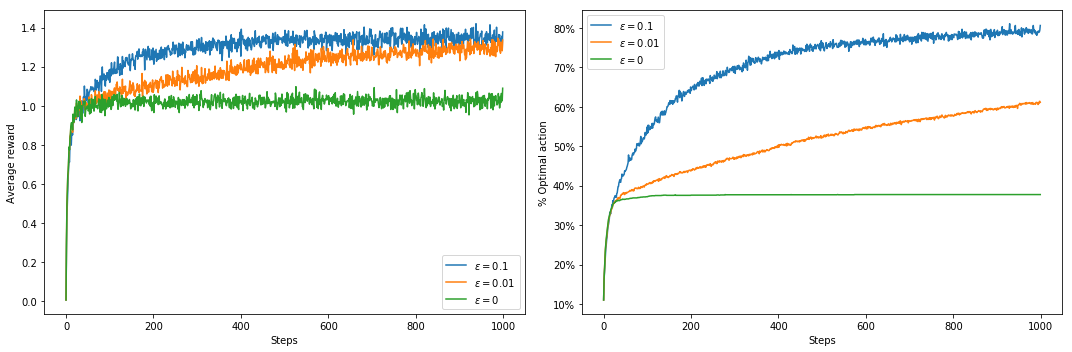

In [5]:
epsilons = [0.1, 0.01, 0]
Rs = [[] for _ in range(len(epsilons))]
Os = [[] for _ in range(len(epsilons))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j in range(len(epsilons)):
        np.random.seed(seed)
        R, O = run(Method.SAMPLE_AVERAGE, epsilon=epsilons[j])
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for e in range(len(epsilons)):
        plt.plot(np.mean(Ys[e], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    plt.legend([fr'$\epsilon = {str(eps)}$' for eps in epsilons])

plt.tight_layout()
plt.show()

# Exercise 2.5

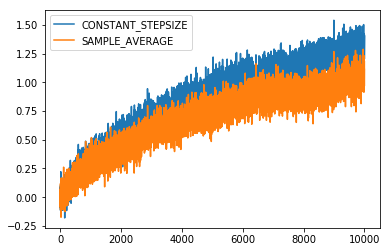

In [6]:
methods = [Method.CONSTANT_STEPSIZE, Method.SAMPLE_AVERAGE]
Rs = [[] for _ in range(len(methods))]

for i in range(200):
    seed = np.random.randint(max_int)
    
    for j in range(len(methods)):
        np.random.seed(seed)
        R = run(methods[j], epsilon=0.1, n_steps=10000, stationary=False)
        Rs[j].append(R)
    
for i in range(len(methods)):
    plt.plot(np.mean(Rs[i], axis=0))
plt.legend([method.name for method in methods])

plt.show()

# Section 2.6: Optimistic Initial Values

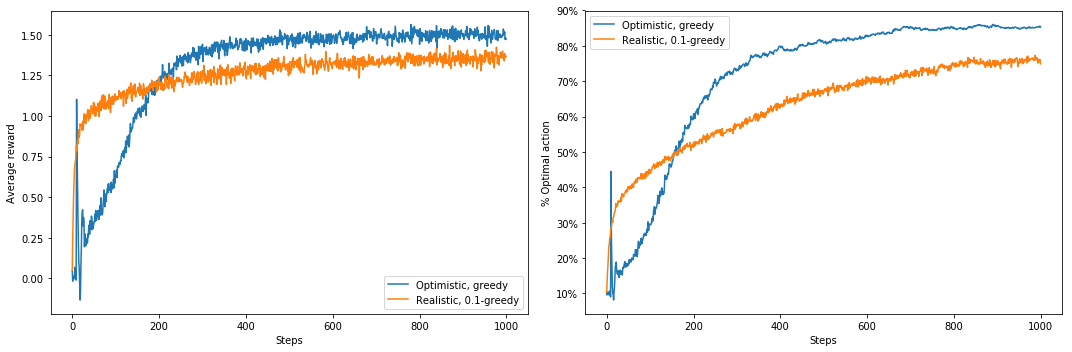

In [7]:
configs = [
    {'optimistic': True, 'epsilon': 0, 'name': 'Optimistic, greedy'},
    {'optimistic': False, 'epsilon': 0.1, 'name': 'Realistic, 0.1-greedy'},
]
Rs = [[] for _ in range(len(configs))]
Os = [[] for _ in range(len(configs))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j, config in enumerate(configs):
        np.random.seed(seed)
        R, O = run(Method.CONSTANT_STEPSIZE, **config)
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for j in range(len(configs)):
        ax.plot(np.mean(Ys[j], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    ax.legend([config['name'] for config in configs])

plt.tight_layout()
plt.show()

# Exercise 2.6

In [8]:
# The mysterious spike occurs at the 11-th step.
# The reason is that after the first 10 actions,
# all of the 10 arms must have been explored,
# and it's likely that the next action is the optimal one.

early = np.mean(Os[0], axis=0)[:100]
np.argmax(early)

10

# Section 2.7: Upper-Confidence-Bound Action Selection

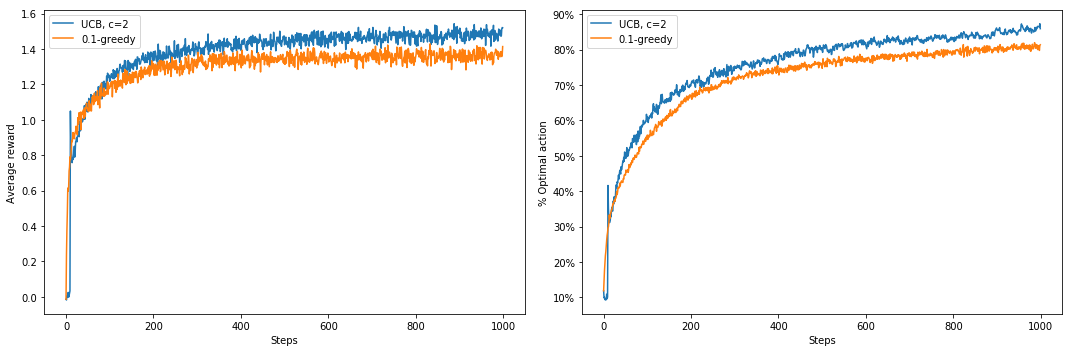

In [9]:
configs = [
    {'ucb': True, 'epsilon': 0, 'name': 'UCB, c=2'},
    {'ucb': False, 'epsilon': 0.1, 'name': '0.1-greedy'},
]
Rs = [[] for _ in range(len(configs))]
Os = [[] for _ in range(len(configs))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j, config in enumerate(configs):
        np.random.seed(seed)
        R, O = run(Method.SAMPLE_AVERAGE, **config)
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for j in range(len(configs)):
        ax.plot(np.mean(Ys[j], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    ax.legend([config['name'] for config in configs])

plt.tight_layout()
plt.show()

# Section 2.8: Gradient Bandit Algorithms

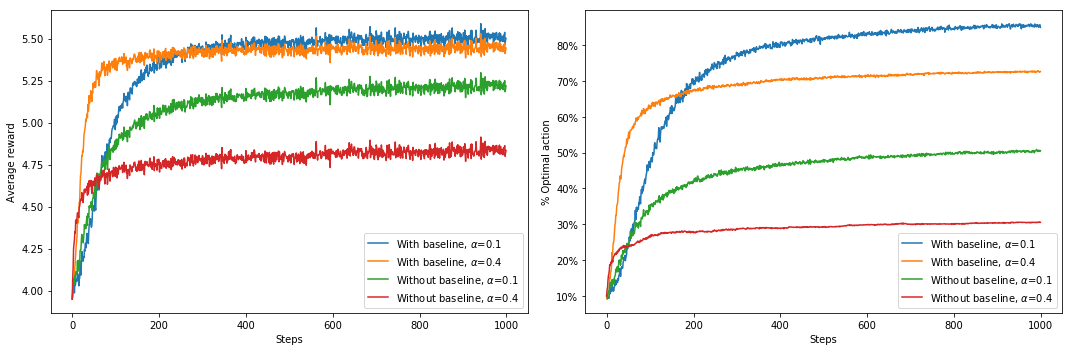

In [10]:
configs = [
    {'gradient_bandit_baseline': True, 'alpha': 0.1, 'name': r'With baseline, $\alpha$=0.1'},
    {'gradient_bandit_baseline': True, 'alpha': 0.4, 'name': r'With baseline, $\alpha$=0.4'},
    {'gradient_bandit_baseline': False, 'alpha': 0.1, 'name': r'Without baseline, $\alpha$=0.1'},
    {'gradient_bandit_baseline': False, 'alpha': 0.4, 'name': r'Without baseline, $\alpha$=0.4'},
]
Rs = [[] for _ in range(len(configs))]
Os = [[] for _ in range(len(configs))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j, config in enumerate(configs):
        np.random.seed(seed)
        R, O = run(Method.GRADIENT_BANDIT, mean=4.0, **config)
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for j in range(len(configs)):
        ax.plot(np.mean(Ys[j], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    ax.legend([config['name'] for config in configs])

plt.tight_layout()
plt.show()

# Section 2.10: Summary

In [11]:
def rationalize(x):
    return str(int(2**x)) if x >= 0 else '1/' + str(int(2**(-x)))

def multicolor_label(ax, strings, colors, anchorpad=0, **kw):
    # https://stackoverflow.com/a/33162465/6607231
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    boxes = [TextArea(text, textprops=dict(color=color, ha='left', va='bottom', **kw)) 
             for text, color in zip(strings, colors)]
    xbox = HPacker(children=boxes, align='center', pad=-20, sep=10)
    anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad, frameon=False,
                                      bbox_to_anchor=(0.45, -0.09),
                                      bbox_transform=ax.transAxes, borderpad=0.)
    ax.add_artist(anchored_xbox)

configs = [
    {'name': r'$\epsilon$-greedy', 'method': Method.SAMPLE_AVERAGE,
     'param': 'epsilon', 'param_range': range(-7, 0)},
    {'name': r'$\epsilon$-greedy with constant step size $\alpha$=0.1', 'method': Method.CONSTANT_STEPSIZE,
     'param': 'epsilon', 'param_range': range(-7, 0)},
    {'name': 'gradient bandit', 'method': Method.GRADIENT_BANDIT,
     'param': 'alpha', 'param_range': range(-6, 1)},
    {'name': 'UCB', 'method': Method.SAMPLE_AVERAGE, 'ucb': True,
     'param': 'ucb_c', 'param_range': range(-4, 3)},
    {'name': r'greedy with optim. init., $\alpha$=0.1', 'method': Method.CONSTANT_STEPSIZE, 'optimistic': True,
     'param': 'optimistic_initial_value', 'param_range': range(-4, 3)},
]
start = min(config['param_range'].start for config in configs)
stop = max(config['param_range'].stop for config in configs)
range_union = range(start, stop)

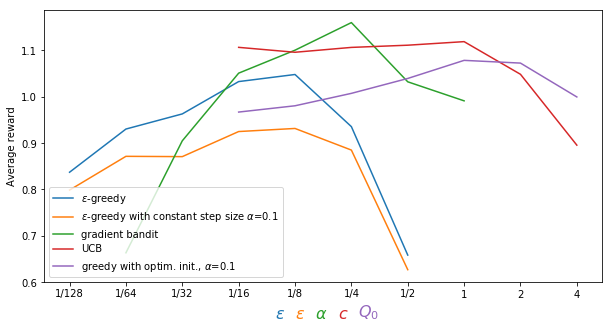

In [12]:
n_runs = 100
Rs = [[[] for _ in range(n_runs)] for _ in range(len(configs))]

for i in range(n_runs):
    seed = np.random.randint(max_int)

    for j, config in enumerate(configs):
        for p in config['param_range']:
            np.random.seed(seed)
            config[config['param']] = 2**p
            R = run(**config)
            Rs[j][i].append(np.mean(R))

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
for i in range(len(configs)):
    ax.plot(configs[i]['param_range'], np.mean(Rs[i], axis=0))
ax.set_ylabel('Average reward')
ax.set_xticks(range_union)
ax.set_xticklabels(map(rationalize, range_union))
ax.legend([config['name'] for config in configs])
multicolor_label(ax, [r'$\epsilon$', r'$\epsilon$', r'$\alpha$', r'$c$', r'$Q_0$'],
                 [f'C{i}' for i in range(len(configs))], size=16)

plt.show()

# Exercise 2.11

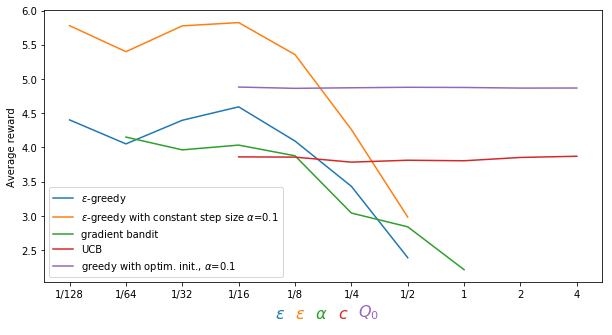

In [13]:
n_runs = 100
n_steps = 200000
Rs = [[[] for _ in range(n_runs)] for _ in range(len(configs))]

for i in range(n_runs):
    seed = np.random.randint(max_int)

    for j, config in enumerate(configs):
        for p in config['param_range']:
            np.random.seed(seed)
            config[config['param']] = 2**p
            R = run(n_steps=n_steps, stationary=False, **config)
            Rs[j][i].append(np.mean(R[n_steps//2:]))

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
for i in range(len(configs)):
    ax.plot(configs[i]['param_range'], np.mean(Rs[i], axis=0))
ax.set_ylabel('Average reward')
ax.set_xticks(range_union)
ax.set_xticklabels(map(rationalize, range_union))
ax.legend([config['name'] for config in configs])
multicolor_label(ax, [r'$\epsilon$', r'$\epsilon$', r'$\alpha$', r'$c$', r'$Q_0$'],
                 [f'C{i}' for i in range(len(configs))], size=16)

plt.show()